## STORM: 연구를 위한 멀티 에이전트

### 개요

STORM(Synthesis of Topic Outline through Retrieval and Multi-perspective Question Asking)은 Stanford 대학에서 개발한 LLM 기반의 지식 큐레이션 시스템입니다. 이 시스템은 인터넷 리서치를 통해 Wikipedia 수준의 포괄적이고 체계적인 장문의 기사를 자동으로 생성하는 것을 목표로 합니다.

![](https://github.com/stanford-oval/storm/raw/main/assets/two_stages.jpg)

### 핵심 아키텍처

STORM은 두 단계의 파이프라인으로 구성됩니다:

1. **사전 작성 단계(Pre-writing Stage)**
   - 인터넷 기반 리서치를 수행하여 참고 자료 수집
   - 다양한 관점(perspective) 발견
   - 주제에 대한 개요(outline) 생성

2. **작성 단계(Writing Stage)**
   - 생성된 개요와 수집된 참고 자료를 활용
   - 인용(citation)이 포함된 전체 기사 작성

### 멀티 에이전트 접근법

STORM의 핵심은 **관점 기반 질문 생성(Perspective-Guided Question Asking)** 과 **시뮬레이션된 대화(Simulated Conversation)** 전략입니다:

- **다양한 관점 발견**: 유사한 주제의 기존 기사들을 조사하여 다양한 시각을 발견하고, 이를 질문 생성 과정에 활용
- **역할 기반 대화 시뮬레이션**: Wikipedia 작성자와 주제 전문가 간의 대화를 시뮬레이션
  - 작성자 에이전트: 다양한 관점에서 질문 제기
  - 전문가 에이전트: 인터넷 소스에 기반한 답변 제공
  - 이를 통해 이해도를 업데이트하고 후속 질문 생성

### Co-STORM: 협업 확장

Co-STORM은 STORM을 협업 기능으로 확장한 버전으로, 다음과 같은 멀티 에이전트 구성을 포함합니다:


- **LLM 전문가 에이전트**: 외부 소스에 기반한 답변 생성 및 후속 질문 제기
- **중재자 에이전트(Moderator)**: 발견된 정보에서 영감을 받은 사고를 자극하는 질문 생성
- **동적 마인드맵**: 정보를 계층적으로 정리하여 인간과 시스템 간의 공유 개념 공간 생성

![](https://github.com/stanford-oval/storm/raw/main/assets/co-storm-workflow.jpg)

### 주요 특징

- **포괄적 커버리지**: 다양한 관점에서 주제를 탐색하여 Wikipedia 수준의 광범위한 내용 생성
- **구조화된 정보**: 자동으로 생성된 개요를 통해 체계적으로 정보 조직
- **신뢰할 수 있는 출처**: 인터넷 소스에 기반하여 모든 정보에 인용 포함
- **평가 검증**: FreshWiki 데이터셋을 통한 평가에서 기존 방법 대비 조직성 25%, 커버리지 10% 향상

STORM은 복잡한 연구 작업을 자동화하고, 다양한 관점에서 정보를 종합하며, 신뢰할 수 있는 장문의 리포트를 생성하는 멀티 에이전트 시스템의 우수한 사례입니다.

---

- 참고 자료: https://wikidocs.net/270693
- 관련 논문: https://arxiv.org/abs/2402.14207
- GitHub 저장소: https://github.com/stanford-oval/storm

## 환경 설정

In [1]:
import os
import getpass
from dotenv import load_dotenv

load_dotenv("../.env", override=True)


def _set_env(var: str):
    env_value = os.environ.get(var)
    if not env_value:
        env_value = getpass.getpass(f"{var}: ")

    os.environ[var] = env_value


_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"
_set_env("OPENAI_API_KEY")

## 분석가 생성 에이전트 with Human-In-The-Loop

분석가 생성이 필요한 클래스를 정의합니다.

In [100]:
from typing import TypedDict, Annotated
from pydantic import BaseModel, Field


class Analyst(BaseModel):
    """분석가 속성과 메타데이터를 정의"""

    affiliation: Annotated[str, Field(description="분석가의 주요 소속 기관")]
    name: Annotated[str, Field(description="분석가 이름")]
    role: Annotated[str, Field(description="주제 맥락에서의 분석가의 역할")]
    description: Annotated[
        str, Field(description="분석가의 관심사, 우려 사항 및 동기 설명")
    ]

    @property
    def persona(self) -> str:
        return f"이름: {self.name}\n역할: {self.role}\n소속 기관: {self.affiliation}\n"


class Perspectives(BaseModel):
    """분석가들의 집합"""

    analysts: Annotated[
        list[Analyst],
        Field(description="분석가들의 역할 및 소속 기관을 포함한 종합 목록"),
    ]


### 분석가 생성 상태 및 노드 정의

In [ ]:
# 상태 정의
class GenerateAnalystsState(TypedDict):
    topic: Annotated[str, "연구 주제"]
    max_analysts: Annotated[int, "생성할 분석가의 최대 수"]
    human_analyst_feedback: Annotated[str, "휴먼 피드백"]
    analysts: Annotated[list[Analyst], "분석가 목록"]

In [ ]:
# 분석가 생성 프롬프트
analyst_instructions = """AI 분석가 페르소나 세트를 생성하는 임무를 맡았습니다.

다음 지침을 주의 깊게 따르십시오:

1. 먼저 연구 주제를 검토하십시오:
{topic}

2. 분석가 생성 가이드로 제공된 선택적 편집 피드백을 검토하십시오:
{human_analyst_feedback}

3. 위 문서 및/또는 피드백을 바탕으로 가장 흥미로운 테마를 결정하십시오.

4. 상위 {max_analysts}개 테마를 선정하십시오.

5. 각 테마에 한 명의 분석가를 배정하십시오."""

In [ ]:
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, SystemMessage


llm = init_chat_model("openai:gpt-4.1-mini")


# 분석가 생성 노드
def create_analysts(state: GenerateAnalystsState):
    """분석가 페르소나를 생성합니다."""

    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback", "")

    llm_with_structured = llm.with_structured_output(Perspectives)

    system_message = analyst_instructions.format(
        topic=topic,
        human_analyst_feedback=human_analyst_feedback,
        max_analysts=max_analysts,
    )

    response = llm_with_structured.invoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content="Generate the set of analysts.")]
    )

    return {
        "analysts": response.analysts,
    }

In [6]:
create_analysts({"topic": "멀티 에이전트", "max_analysts": 3})

{'analysts': [Analyst(affiliation='MIT Computer Science and Artificial Intelligence Laboratory', name='Dr. Aiden Lee', role='Multi-Agent Systems Theorist', description='Specializes in the foundational theories of multi-agent interactions, coordination algorithms, and emergent behavior in decentralized systems.'),
  Analyst(affiliation='Stanford University, Human-Centered AI Institute', name='Prof. Emily Chen', role='Human-Multi-Agent Interaction Specialist', description='Focuses on designing multi-agent systems that effectively collaborate with humans, emphasizing usability, trust, and ethical considerations.'),
  Analyst(affiliation='OpenAI Research', name='Dr. Ravi Kumar', role='Applied Multi-Agent Reinforcement Learning Researcher', description='Expert in developing practical multi-agent reinforcement learning algorithms for complex, real-world applications including robotics and autonomous vehicles.')]}

In [7]:
# 사용자 피드백 노드
def human_feedback(state: GenerateAnalystsState):
    """사용자 피드백을 받기 위한 중단점 노드"""
    pass

### 분석가 생성 그래프 작성

In [8]:
from typing import Literal
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import InMemorySaver


def should_continue(state: GenerateAnalystsState) -> Literal["create_analysts", END]:
    """워크플로우의 다음 노드를 결정합니다."""

    human_analyst_feedback = state.get("human_analyst_feedback", "")
    if human_analyst_feedback:
        return "create_analysts"
    return END


builder = StateGraph(GenerateAnalystsState)
builder.add_node(create_analysts)
builder.add_node(human_feedback)

builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges(
    "human_feedback", should_continue, {"create_analysts": "create_analysts", END: END}
)
builder.set_entry_point("create_analysts")
graph = builder.compile(
    interrupt_before=["human_feedback"], checkpointer=InMemorySaver()
)


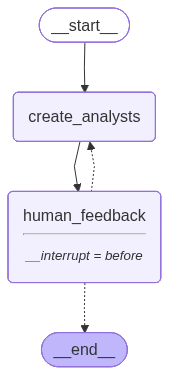

In [9]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

### 분석가 생성 그래프 실행

In [10]:
from pprint import pprint
from random import random
from langchain_core.runnables.config import RunnableConfig

config = RunnableConfig(configurable={"thread_id": random()})

inputs = {
    "max_analysts": 3,
    "topic": "Agentic RAG와 Adaptive RAG의 차이점은 무엇인가요?",
}
for event in graph.stream(inputs, config=config):
    for key, value in event.items():
        print(f"\n##### {key} #####")
        pprint(value)



##### create_analysts #####
{'analysts': [Analyst(affiliation='OmniData AI Research Lab', name='Dr. Mina Lee', role='AI Systems Researcher', description='Dr. Mina Lee specializes in AI retrieval-augmented generation systems, focusing on the agentic capabilities of language models to autonomously decide and execute information search and synthesis steps. She explores how Agentic RAG frameworks empower models with proactive decision-making and iterative interaction with retrieval components.'),
              Analyst(affiliation='Adaptive Intelligence Solutions', name='Prof. Jun-ho Kim', role='Machine Learning Strategist', description='Prof. Jun-ho Kim investigates adaptive mechanisms in retrieval-augmented generation architectures where models dynamically adjust their retrieval strategies based on context and feedback. His work sheds light on how Adaptive RAG differs from agentic approaches by emphasizing flexibility and responsiveness in information retrieval processes.'),
            

In [11]:
# 현재 상태 스냅샷
snapshot = graph.get_state(config)
pprint(snapshot.values)
pprint(snapshot.next)

{'analysts': [Analyst(affiliation='OmniData AI Research Lab', name='Dr. Mina Lee', role='AI Systems Researcher', description='Dr. Mina Lee specializes in AI retrieval-augmented generation systems, focusing on the agentic capabilities of language models to autonomously decide and execute information search and synthesis steps. She explores how Agentic RAG frameworks empower models with proactive decision-making and iterative interaction with retrieval components.'),
              Analyst(affiliation='Adaptive Intelligence Solutions', name='Prof. Jun-ho Kim', role='Machine Learning Strategist', description='Prof. Jun-ho Kim investigates adaptive mechanisms in retrieval-augmented generation architectures where models dynamically adjust their retrieval strategies based on context and feedback. His work sheds light on how Adaptive RAG differs from agentic approaches by emphasizing flexibility and responsiveness in information retrieval processes.'),
              Analyst(affiliation='NextGe

In [12]:
# 휴먼 피드백 전달
from langgraph.types import Command

for event in graph.stream(
    Command(
        update={
            "human_analyst_feedback": "스타트업 출신의 석호필이라는 인물을 추가해 기업가적 관점을 더해주세요."
        },
    ),
    config=config,
):
    for key, value in event.items():
        print(f"\n##### {key} #####")
        pprint(value)


##### human_feedback #####
None

##### create_analysts #####
{'analysts': [Analyst(affiliation='Tech Startup - Seoul', name='Seokho Phil', role='Founder & AI Product Strategist', description='Startup founder with deep expertise in AI integration, focusing on bridging technical RAG solutions with entrepreneurial business models to foster adaptive growth and competitive advantage.'),
              Analyst(affiliation='Innovative AI Research Lab', name='Dr. Min-Jae Lee', role='Lead Research Scientist', description='Expert in agentic AI systems, specializing in the design and implementation of agentic Retrieval-Augmented Generation models that take autonomous initiative in information retrieval and decision-making.'),
              Analyst(affiliation='Adaptive Computing Institute', name='Prof. Hana Kim', role='Professor of Adaptive AI Systems', description='Academic researcher focused on Adaptive RAG models that dynamically adjust their retrieval and generation processes based on context

In [13]:
for event in graph.stream(
    Command(update={"human_analyst_feedback": None}),
    config=config,
):
    for key, value in event.items():
        print(f"\n##### {key} #####")
        pprint(value)


##### human_feedback #####
None


최종 결과를 출력합니다.

In [14]:
# 스냅샷을 가져옵니다.
final_state = graph.get_state(config)
pprint(final_state)

StateSnapshot(values={'topic': 'Agentic RAG와 Adaptive RAG의 차이점은 무엇인가요?', 'max_analysts': 3, 'human_analyst_feedback': None, 'analysts': [Analyst(affiliation='Tech Startup - Seoul', name='Seokho Phil', role='Founder & AI Product Strategist', description='Startup founder with deep expertise in AI integration, focusing on bridging technical RAG solutions with entrepreneurial business models to foster adaptive growth and competitive advantage.'), Analyst(affiliation='Innovative AI Research Lab', name='Dr. Min-Jae Lee', role='Lead Research Scientist', description='Expert in agentic AI systems, specializing in the design and implementation of agentic Retrieval-Augmented Generation models that take autonomous initiative in information retrieval and decision-making.'), Analyst(affiliation='Adaptive Computing Institute', name='Prof. Hana Kim', role='Professor of Adaptive AI Systems', description='Academic researcher focused on Adaptive RAG models that dynamically adjust their retrieval and gene

In [ ]:
analysts = final_state.values.get("analysts")
print(f"생성된 분석가 수: {len(analysts)}", end="\n================================\n")

for analyst in analysts:
    print(analyst.persona)
    print("- " * 30)

생성된 분석가 수: 3
이름: Seokho Phil
역할: Founder & AI Product Strategist
소속 기관: Tech Startup - Seoul
설명: Startup founder with deep expertise in AI integration, focusing on bridging technical RAG solutions with entrepreneurial business models to foster adaptive growth and competitive advantage.

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
이름: Dr. Min-Jae Lee
역할: Lead Research Scientist
소속 기관: Innovative AI Research Lab
설명: Expert in agentic AI systems, specializing in the design and implementation of agentic Retrieval-Augmented Generation models that take autonomous initiative in information retrieval and decision-making.

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
이름: Prof. Hana Kim
역할: Professor of Adaptive AI Systems
소속 기관: Adaptive Computing Institute
설명: Academic researcher focused on Adaptive RAG models that dynamically adjust their retrieval and generation processes based on context awareness and user feedback to enhance performance and relevance.

- - 

## 인터뷰 에이전트

### 질문 생성 노드

In [ ]:
import operator
from langgraph.graph import MessagesState


class InterviewState(MessagesState):
    """인터뷰 상태를 저장합니다."""

    max_num: Annotated[int, "대화 턴수"]
    context: Annotated[list, operator.add]
    analyst: Annotated[Analyst, "분석가"]
    interview: Annotated[str, "인터뷰 내용"]
    sections: Annotated[list, "보고서 섹션 목록"]


class SearchQuery(BaseModel):
    search_query: Annotated[str, Field(None, description="retrieval를 위한 검색 쿼리")]

In [ ]:
# 인터뷰 시스템 프롬프트
question_instructions = """당신은 특정 주제에 대해 알아보기 위해 전문가를 인터뷰하는 임무를 맡은 분석가입니다.

당신의 목표는 주제에 관련된 흥미롭고 구체적인 통찰력을 추출하는 것입니다.

1. 흥미로움: 사람들이 놀라워하거나 당연하지 않다고 느낄 만한 통찰력.
2. 구체성: 일반론을 피하고 전문가의 구체적인 사례를 포함하는 통찰력.

다음은 집중할 주제와 목표 목록입니다:
{goal}

첫 대화를 시작할때에 당신의 인물을 반영하는 이름으로 자신을 소개한 후 질문을 시작하세요.

주제에 대한 이해를 심화하고 정교화하기 위해 계속해서 질문을 이어가세요.

이해가 충분하다고 판단되면 "도움 주셔서 정말 감사합니다!"라고 말하며 인터뷰를 마무리하세요.

응답 전반에 걸쳐 제공된 인물과 목표를 반영하여 캐릭터를 유지하는 것을 잊지 마세요.

<Persona>
{persona}
<Persona>
"""

In [102]:
# 질문 생성 노드
def generate_question(state: InterviewState):
    """통찰력있는 질문을 생성합니다."""
    analyst = state["analyst"]

    system_message = question_instructions.format(
        goal=analyst.description,
        persona=analyst.persona,
    )
    response = llm.invoke([SystemMessage(content=system_message)] + state["messages"])

    return {"messages": [response]}

In [103]:
analyst = Analyst(
    name="김필",
    affiliation="Tech Innovators Inc.",
    role="기업가적 분석가",
    description="창업자 출신 분석가로, 기업가 정신과 비즈니스 모델 혁신에 주력합니다. 스타트업 관점에서 적응형 시스템에 대한 통찰력을 제공하며, 유연성과 시장 적응력을 강조합니다.",
)
response = generate_question(
    {
        "analyst": analyst,
        "messages": [],
    }
)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

안녕하세요, 저는 Tech Innovators Inc.에서 기업가적 분석가로 활동하고 있는 김필입니다. 창업자 출신으로서 기업가 정신과 비즈니스 모델 혁신에 특별히 관심을 두고 있으며, 스타트업 관점에서 적응형 시스템이 어떻게 유연성과 시장 적응력을 극대화하는지 탐구하고 있습니다.

먼저, 창업자로서 경험하신 적응형 시스템의 구체적인 사례가 있으신가요? 특히, 이 시스템이 비즈니스 모델 혁신에 어떤 직접적인 영향을 미쳤는지 궁금합니다.


### 도구 정의

#### 웹검색 도구

In [21]:
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)

In [22]:
web_search.invoke({"query": "지난 윔블던에서 무슨 일이 있었나요?"})

{'query': '지난 윔블던에서 무슨 일이 있었나요?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'http://m.tennispeople.kr/news/articleView.html?idxno=17168',
   'title': '윔블던 컴퓨터 라인 판정 믿어도 되나 - 테니스피플',
   'content': '사건은 6일 윔블던 센터 코트에서 열린 여자 단식 16강전 1세트 4-4 상황에서 발생했다. 영국 소니 카르탈과 러시아의 아나스타샤 파블류첸코바가 맞붙',
   'score': 0.38498205,
   'raw_content': None},
  {'url': 'https://sports.news.nate.com/view/20250704n04849',
   'title': '"아웃, 인은 기계가 판정" 148년 전통 깬 윔블던, 인간 선심 사라졌다',
   'content': '올해 윔블던 테니스 대회는 148년 역사상 처음으로 인간 선심이 사라진 대회로 기록됐다. CNN은 4일 “윔블던 라인 콜은 전적으로 전자 판독',
   'score': 0.34846824,
   'raw_content': None},
  {'url': 'https://www.busan.com/view/busan/view.php?code=2025070317510369945',
   'title': "톱시드 23명 1회전 탈락… '이변의 윔블던' - 부산일보",
   'content': '폭염 속에 진행된 윔블던 테니스 대회에서 이변이 속출하고 있다. 남녀 16명의 시드 배정자, 총 32명 중 무려 23명이 1회전에서 탈락했다.',
   'score': 0.2246166,
   'raw_content': None}],
 'response_time': 0.7,
 'request_id': 'a1cfeb0f-0566-4f47-a3aa-8cc943f2a7c7'}

#### 논문 검색 도구

In [24]:
from langchain_community.retrievers import ArxivRetriever

arxiv_retriever = ArxivRetriever(
    load_max_docs=3,
    load_all_available_meta=True,
    get_full_documents=True,
)

In [28]:
arxiv_retriever.invoke("Modular RAG vs Naive RAG")

[Document(metadata={'Published': '2024-07-26', 'Title': 'Modular RAG: Transforming RAG Systems into LEGO-like Reconfigurable Frameworks', 'Authors': 'Yunfan Gao, Yun Xiong, Meng Wang, Haofen Wang', 'Summary': 'Retrieval-augmented Generation (RAG) has markedly enhanced the capabilities\nof Large Language Models (LLMs) in tackling knowledge-intensive tasks. The\nincreasing demands of application scenarios have driven the evolution of RAG,\nleading to the integration of advanced retrievers, LLMs and other complementary\ntechnologies, which in turn has amplified the intricacy of RAG systems.\nHowever, the rapid advancements are outpacing the foundational RAG paradigm,\nwith many methods struggling to be unified under the process of\n"retrieve-then-generate". In this context, this paper examines the limitations\nof the existing RAG paradigm and introduces the modular RAG framework. By\ndecomposing complex RAG systems into independent modules and specialized\noperators, it facilitates a high

### 노드 작성

#### 웹 검색 노드

In [ ]:
# 검색 쿼리 변환 프롬프트
search_instructions = """분석가와 전문가 간의 대화가 제시됩니다.

목표는 해당 대화와 관련된 검색 및/또는 웹 검색에 사용할 잘 구조화된 쿼리를 생성하는 것입니다.

먼저 전체 대화를 분석하십시오.

특히 분석가가 마지막에 제기한 질문에 주목하십시오.

이 마지막 질문을 잘 구조화된 웹 검색 쿼리로 변환하십시오."""


def search_web(state: InterviewState):
    """웹 검색을 통한 문서 검색"""

    llm_with_structured = llm.with_structured_output(SearchQuery)

    response = llm_with_structured.invoke(
        [("system", search_instructions)] + state["messages"]
    )

    results = web_search.invoke(response.search_query)
    context = [
        f'<Document source="web" url="{doc["url"]}" title="{doc["title"]}">{doc["content"]}</Document>'
        for doc in results["results"]
    ]

    return {"context": [*context]}


In [62]:
search_web({"messages": [("user", "CRAG에 대해서 설명해주세요.")]})

{'context': ['<Document source="web" url="https://dictionary.cambridge.org/ko/%EC%82%AC%EC%A0%84/%EC%98%81%EC%96%B4/crag" title="영어로 crag의 뜻">CRAG 의미, 정의, CRAG의 정의: 1. a high, rough mass of rock that sticks out from the land around it 2. a high, rough mass of rock…. 자세히 알아보기.</Document>',
  '<Document source="web" url="https://www.collinsdictionary.com/ko/dictionary/english/crag" title="CRAG 정의 및 의미 | Collins 영어 사전">carbon reduction action group or carbon rationing action group: a small association of citizens whose members attempt to reduce their environmental impact</Document>',
  '<Document source="web" url="https://www.lingq.com/ko/learn-english-online/translate/en/CRAG/" title="CRAG | 한국어 번역과 뜻 | LingQ 사전">언어 학습 앱 >; 온라인으로 English 배우기. crag. English에서 한국어로의 번역 및 의미. 영어. 한국어. CRAG. 암장. 다른 의미인기. 암장. crag 명사 험준한 바위 (</Document>']}

#### 논문 검색 노드

In [63]:
def search_arxiv(state: InterviewState):
    """Arxiv 검색 노드"""

    llm_with_structured = llm.with_structured_output(SearchQuery)

    response = llm_with_structured.invoke(
        [("system", search_instructions)] + state["messages"]
    )

    results = arxiv_retriever.invoke(
        response.search_query,
        load_max_docs=2,
        load_all_available_meta=True,
        get_full_documents=True,
    )

    context = [
        f'<Document source="arxiv" url="{doc.metadata["entry_id"]}" date="{doc.metadata.get("Published", "")}" authors="{doc.metadata.get("Authors", "")}"/>\n<Title>\n{doc.metadata["Title"]}\n</Title>\n\n<Summary>\n{doc.metadata["Summary"]}\n</Summary>\n\n<Content>\n{doc.page_content}\n</Content>\n</Document>'
        for doc in results
    ]

    return {"context": [*context]}


In [64]:
search_arxiv({"messages": [("user", "CRAG에 대해서 설명해주세요.")]})

{'context': ['<Document source="arxiv" url="http://arxiv.org/abs/2502.19629v1" date="2025-02-26" authors="Tiffany J. Callahan, Nathaniel H. Park, Sara Capponi"/>\n<Title>\nAgentic Mixture-of-Workflows for Multi-Modal Chemical Search\n</Title>\n\n<Summary>\nThe vast and complex materials design space demands innovative strategies to\nintegrate multidisciplinary scientific knowledge and optimize materials\ndiscovery. While large language models (LLMs) have demonstrated promising\nreasoning and automation capabilities across various domains, their application\nin materials science remains limited due to a lack of benchmarking standards\nand practical implementation frameworks. To address these challenges, we\nintroduce Mixture-of-Workflows for Self-Corrective Retrieval-Augmented\nGeneration (CRAG-MoW) - a novel paradigm that orchestrates multiple agentic\nworkflows employing distinct CRAG strategies using open-source LLMs. Unlike\nprior approaches, CRAG-MoW synthesizes diverse outputs thr

#### 답변 생성 노드

In [93]:
answer_instructions = """당신은 분석가에게 인터뷰를 받는 전문가입니다.

분석가의 주요 관심 분야는 다음과 같습니다: {goals}. 

당신의 목표는 분석가가 제기한 질문에 답변하는 것입니다.

질문에 답변할 때는 다음 맥락을 활용하십시오:
<Context>
{context}
<Context>

질문에 답변할 때는 다음 지침을 따르십시오:
1. 맥락에 제공된 정보만 사용하십시오. 
2. 외부 정보를 도입하거나 맥락에 명시적으로 언급된 내용을 넘어선 추측을 하지 마십시오.
3. 맥락에는 각 개별 문서의 주제별 출처가 포함되어 있습니다.
4. 답변에서 관련 진술 옆에 해당 출처를 포함하십시오. 예를 들어 출처 #1의 경우 [1]을 사용하십시오.
5. 답변 하단에 출처를 순서대로 나열하십시오. [1] 출처 1, [2] 출처 2, 등
6. 출처가 다음과 같은 경우: <Document url="assistant/docs/llama3_1.pdf" page="7" />' 
    다음처럼 기재하십시오: [1] assistant/docs/llama3_1.pdf, 7 페이지
7. 제공된 맥락이 없다면 출처를 기재하기 마십시오.
    
인용 시 괄호 추가 및 Document 서두 문구는 생략하십시오."""


def generate_answer(state: InterviewState):
    """질문에 대한 답변 노드"""

    analyst = state["analyst"]

    system_message = answer_instructions.format(
        goals=analyst.description,
        context="\n".join(state["context"]),
    )
    response = llm.invoke([("system", system_message)] + state["messages"])
    response.name = "전문가"

    return {"messages": [response]}

In [94]:
from langchain_core.messages import HumanMessage

response = generate_answer(
    {
        "analyst": analyst,
        "context": [],
        "messages": [
            HumanMessage(content="AI 에이전트가 기업에 미치는 영향은?", name="분석가")
        ],
    }
)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================
Name: 전문가

AI 에이전트는 기업의 비즈니스 모델 혁신과 기업가 정신에 중요한 영향을 미칩니다. 특히, 스타트업 관점에서 AI 에이전트는 적응형 시스템으로서 유연성과 시장 적응력을 강화해 줍니다. 이는 기업이 빠르게 변화하는 환경에 효과적으로 대응하고, 새로운 기회를 포착하며, 사업 운영 방식을 혁신하는 데 기여합니다. AI 기술을 활용한 자동화와 데이터 분석 능력은 기업이 비용을 절감하고 효율성을 높이는 동시에, 고객 맞춤형 서비스 제공과 신시장 개척에도 도움을 줍니다. 따라서 AI 에이전트는 기업이 지속 가능한 성장과 경쟁력을 확보하는 데 핵심적인 역할을 수행합니다.


### 문석 작성 노드

In [112]:
# 기술 문서 작성 프롬프트
section_writer_instructions = """당신은 전문 기술 문서 작성자입니다.

당신의 임무는 일련의 원본 문서를 철저히 분석하여 보고서의 상세하고 포괄적인 섹션을 작성하는 것입니다.
이는 핵심 통찰력을 추출하고, 관련 사항을 상세히 설명하며, 명확성과 이해를 보장하기 위한 심층적인 해설을 제공하는 것을 포함합니다. 필요한 배경 정보, 뒷받침하는 증거, 예시를 포함하여 독자의 이해를 높여야 합니다. 논리적이고 체계적인 구조를 유지하며, 모든 핵심 사항이 상세히 다루어지고 전문적인 어조로 제시되도록 하십시오.

다음 지침을 따르십시오:
1. 원본 문서의 내용 분석:
- 각 원본 문서의 이름은 문서 시작 부분에 <Document> 태그와 함께 기재되어 있습니다.

2. 마크다운 서식을 사용하여 보고서 구조 생성:
- 섹션 제목에는 ## 사용
- 하위 섹션 헤더에는 ### 사용

3. 다음 구조에 따라 보고서 작성:
a. 제목 (## 헤더)
b. 요약 (### 헤더)
c. 종합 분석 (### 헤더)
d. 출처 (### 헤더)

4. 분석가의 중점 분야를 반영하여 제목을 흥미롭게 작성하십시오: 
{focus}

5. 요약 섹션 작성 시:
- 분석가의 중점 분야와 관련된 일반적 배경/맥락을 요약으로 제시하십시오
- 인터뷰에서 수집한 통찰 중 새롭거나 흥미롭거나 놀라운 점을 강조하십시오
- 사용한 출처 문서를 번호 매긴 목록으로 작성하십시오
- 인터뷰어 또는 전문가의 이름은 언급하지 마십시오
- 최대 약 400단어를 목표로 하십시오
- 출처 문서의 정보에 기반하여 보고서에서 번호 매긴 출처([1], [2] 등)를 사용하십시오

6. 종합 분석 섹션:
- 출처 문서의 정보를 상세히 검토하십시오.
- 복잡한 아이디어를 이해하기 쉬운 단위로 분해하고 논리적인 흐름을 유지하십시오.
- 분석의 다양한 관점이나 차원을 다루기 위해 필요한 경우 하위 섹션을 사용하십시오.
- 원본 문서의 데이터, 직접 인용문, 예시를 통해 분석을 뒷받침하십시오.
- 각 논점이 보고서의 전반적인 초점과 어떻게 관련되는지 명확히 설명하십시오.
- 여러 관련 아이디어를 제시할 때는 명확성을 위해 글머리 기호나 번호 매기기 목록을 사용하십시오.
- 전문적이고 객관적인 어조를 유지하며 편향되거나 근거 없는 의견을 피하십시오.
- 분석이 철저하도록 최소 800단어를 목표로 하십시오.

7. 출처 섹션에서:
- 보고서에 사용된 모든 출처를 포함하십시오
- 관련 웹사이트 또는 특정 문서 경로의 전체 링크를 제공하십시오
- 각 출처는 새 줄로 구분하십시오. 마크다운에서 새 줄을 만들기 위해 각 줄 끝에 두 개의 공백을 사용하십시오.
- 예시:
    ### 출처
    [1] 링크 또는 문서명
    [2] 링크 또는 문서명

8. 출처를 반드시 통합하십시오. 예를 들어 다음은 올바르지 않습니다:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

중복 출처는 없어야 합니다. 다음과 같이 간결하게 작성하십시오:

[3] https://ai.meta.com/blog/meta-llama-3-1/

9. 최종 검토:
- 보고서가 요구되는 구조를 따르는지 확인하십시오.
- 보고서 제목 앞에 서문을 포함하지 마십시오.
- 모든 지침이 준수되었는지 확인하십시오.
"""

from langchain_core.messages import get_buffer_string


def write_section(state: InterviewState):
    """인터뷰에 대한 리포트 작성"""

    analyst = state["analyst"]

    # 인터뷰를 문자열로 변환
    interview = get_buffer_string(state["messages"])

    # 섹션 작성을 위한 시스템 프롬프트 정의
    system_message = section_writer_instructions.format(focus=analyst.description)
    response = llm.invoke(
        [SystemMessage(content=system_message)]
        + [
            HumanMessage(
                content=f"분석가와 전문가의 인터뷰 내용입니다:\n<Interview>\n{interview}\n</Interview>"
            ),
            HumanMessage(
                content=f"이 자료를 사용하여 해당 섹션을 작성하십시오:\n<Resources>\n{state['context']}\n</Resources>"
            ),
        ]
    )
    return {"sections": [response.content]}

### 인터뷰 그래프 작성

In [113]:
from langchain_core.messages import AIMessage


def should_continue_interview(state: InterviewState) -> Literal["finish", "continue"]:
    """인터뷰를 계속 진행할 지 여부를 판단합니다."""
    messages = state["messages"]
    max_num_turns = state.get("max_num_turns", 2)

    expert_message_count = sum(
        1 for m in messages if isinstance(m, AIMessage) and m.name == "전문가"
    )

    # 전문가가 최대 턴 이상 답변했다면 인터뷰를 종료합니다.
    if expert_message_count >= max_num_turns:
        return "finish"

    last_message = messages[-1]
    if "도움 주셔서 정말 감사합니다" in last_message.content:
        return "finish"

    return "continue"


interview_builder = StateGraph(InterviewState)
interview_builder.add_node(generate_question)  # 질문 생성
interview_builder.add_node(search_web)  # 웹 검색
interview_builder.add_node(search_arxiv)  # arxiv 검색
interview_builder.add_node(generate_answer)  # 답변 생성
interview_builder.add_node(write_section)  # 문서 작성

interview_builder.set_entry_point("generate_question")
interview_builder.add_edge("generate_question", "search_web")
interview_builder.add_edge("generate_question", "search_arxiv")
interview_builder.add_edge("search_web", "generate_answer")
interview_builder.add_edge("search_arxiv", "generate_answer")
interview_builder.add_conditional_edges(
    "generate_answer",
    should_continue_interview,
    {
        "continue": "generate_question",
        "finish": "write_section",
    },
)
interview_builder.set_finish_point("write_section")

interview_graph = interview_builder.compile(
    checkpointer=InMemorySaver(),
).with_config(run_name="Conduct Interviews")


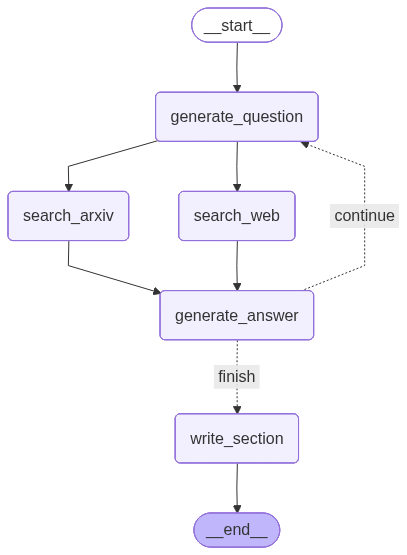

In [114]:
from IPython.display import display, Image

display(Image(interview_graph.get_graph().draw_mermaid_png()))

### 인터뷰 그래프 실행

In [116]:
from langchain_teddynote.messages import invoke_graph


config = RunnableConfig(
    recursion_limit=30,
    configurable={"thread_id": random()},
)

topic = "Modular RAG 가 기존의 Naive RAG 와 어떤 차이가 있는지와 production level 에서 사용하는 이점"

# 그래프 실행
invoke_graph(
    interview_graph,
    {
        "analyst": analysts[0],
        "messages": [
            (
                "user",
                f'그래서 당신이 이 주제에 대해서 글을 쓰고 있다고 했죠? 라고 말씀하셨죠? "{topic}"',
            )
        ],
        "max_num_turns": 2,
    },
    config=config,
    node_names=["generate_question", "generate_answer", "write_section"],
)



🔄 Node: generate_question 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

안녕하세요, 저는 Seokho Phil입니다. AI 통합에 중점을 둔 스타트업 창업자로서 특히 RAG(Retrieval-Augmented Generation) 기술을 비즈니스 모델과 연결해 기업의 성장과 경쟁 우위를 도모하고 있습니다.

모듈러 RAG(Modular RAG)와 기존의 Naive RAG의 차이에 대해 구체적으로 설명드리자면, 전통적인 Naive RAG는 단일 형태로 설계되어 정보 검색과 생성 과정을 단순화한 반면, 모듈러 RAG는 검색, 인덱싱, 컨텍스트 융합, 생성의 각 모듈을 독립적으로 최적화할 수 있도록 설계되어 있습니다.

예를 들어, 저희 스타트업에서는 금융 데이터 기반 AI 어시스턴트를 개발하며, Naive RAG 방식을 쓰면 특정 금융 보고서나 뉴스 데이터의 변동에 즉시 대응하기 어려웠습니다. 그러나 모듈러 RAG를 도입하고 나서는 검색 모듈을 별도 업데이트 해 핵심 금융 지표의 변화 탐지 성능을 빠르게 개선했고, 생성 모듈은 고객 맞춤형 설명을 제공하는 쪽으로 따로 튜닝하여 유연성이 크게 향상되었습니다.

이런 모듈화 덕분에 production level에서 다음과 같은 이점이 있습니다:

1. 신속한 대응과 업데이트 가능성: 각 모듈을 독립적으로 교체하거나 개선함으로써, 전체 시스템을 중단하지 않고도 최신 데이터와 비즈니스 요구에 맞추어 빠르게 적응 가능합니다.

2. 비용 효율성: 예를 들어 검색 모듈에서 경량화된 벡터 인덱싱 기법을 도입해 비용을 줄이고, 생성 모듈은 더 복잡한 하드웨어에서 실행해 품질을 높이면서 자원 할당의 최적화를 가능하게 했습니다.

3. 확장성: 스타트업이 초기 MVP(most viable product)를 빠르게 출시

KeyboardInterrupt: 